In [241]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal
import pandas as pd
import sklearn
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [242]:
class PCA:
    
    """
    Standardize the data by subtracting respective means of features
    """
    
    def standardize(self,data_input):
        mean = np.mean(data_input,axis = 0)
        return data_input - mean
    
    """
    Extract the eigen values from X-transpose-X
    X-transpose-X => Covariance matrix
    """
    
    def eigenvalueExtraction(self,data_input):
        std_data = self.standardize(data_input)
        cov_matrix = np.matmul(std_data.T, std_data)
        eigen_vals, eigen_vectors = np.linalg.eig(cov_matrix)
        return std_data,eigen_vals,eigen_vectors
    
    """
    Select k eigen vectors for dimensionality reduction
    """
    
    def dimensionReduction(self,eig_val,eig_vec,k):
        return eig_val[:k],eig_vec[:,:k]
    
    """
    Reconstruction step for the scaled input data (normalized)
    """
    
    def reconstruction(self,scaled_X,eig_vec):
        return np.matmul(scaled_X,eig_vec)

    """
    Master function for applying PCA on a feature vector/vectors
    """
    
    def apply_pca(self,data,k=1):
        A, eigen_vals, eigen_vectors = self.eigenvalueExtraction(data)
        eigen_vals_red , eigen_vectors_red = self.dimensionReduction(eigen_vals,eigen_vectors,k)
        red_output_matrix = self.reconstruction(A,eigen_vectors_red)
        return A,eigen_vals,eigen_vectors,red_output_matrix

<h2>Read Customer dataset</h2>

In [243]:
data = pd.read_csv('./problem2-dataset1/data.csv')

In [244]:
data

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


In [245]:
data_to_np = np.array(data)
data_to_np.shape

(2000, 8)

In [246]:
# remove index column above which is unrelated to our usecase
processed_data = data_to_np[:,1:]

In [247]:
processed_data.shape

(2000, 7)

In [329]:
# This class made some by ChatGPT
# made some by me
class GMM(PCA):
    def __init__(self):
        self.weights = None
        self.means = None
        self.covariances = None
        self.n_components = None

    def initialize_parameters(self, data, n_components,feature_extract,flag):
        self.n_components = n_components
        self.weights = np.ones(self.n_components) / self.n_components
        self.k = feature_extract
        if flag==0:
            _,_,_,self.reduced_pca_data = self.apply_pca(data,feature_extract)
        else:
            self.reduced_pca_data = data
        self.means = self.reduced_pca_data[np.random.choice(self.reduced_pca_data.shape[0], self.n_components, replace=False), :]
        self.covariances = [np.cov(self.reduced_pca_data, rowvar=False)] * self.n_components

    def e_step(self, data):
        responsibilities = np.zeros((data.shape[0], self.n_components))
        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * multivariate_normal(self.means[i], self.covariances[i]).pdf(data)
        
        responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
        
        return responsibilities

    def m_step(self, data, responsibilities):
        for i in range(self.n_components):
            weight = responsibilities[:, i].sum()
            mean = (data * responsibilities[:, i, np.newaxis]).sum(axis=0) / weight
            covariance = np.dot((responsibilities[:, i, np.newaxis] * (data - mean)).T, (data - mean)) / weight

            self.weights[i] = weight / data.shape[0]
            self.means[i] = mean
            self.covariances[i] = covariance

    def compute_log_likelihood(self):
        log_likelihood = 0
        for i in range(self.n_components):
            log_likelihood += self.weights[i] * multivariate_normal(self.means[i], self.covariances[i]).pdf(self.reduced_pca_data)
        return np.log(log_likelihood).sum()

    def fit(self, data, n_components,feature_extract=3,tol=1e-4, max_iter=100,flag=0):
        self.initialize_parameters(data, n_components,feature_extract,flag)
        log_likelihood = 0
        for iteration in range(max_iter):
            responsibilities = self.e_step(self.reduced_pca_data)
            self.m_step(self.reduced_pca_data, responsibilities)
            new_log_likelihood = self.compute_log_likelihood()
            
            if abs(new_log_likelihood - log_likelihood) < tol:
                break
            log_likelihood = new_log_likelihood

    def get_parameters(self):
        return {
            "weights": self.weights,
            "means": self.means,
            "covariances": self.covariances
        }

    def predict(self, data):
        likelihoods = np.zeros((data.shape[0], self.n_components))
        for i in range(self.n_components):
            likelihoods[:, i] = self.weights[i] * multivariate_normal(self.means[i], self.covariances[i]).pdf(data)
        return likelihoods

    def predict_membership(self):
        responsibilities = self.e_step(self.reduced_pca_data)
        return responsibilities.argmax(axis=1)

    def compute_aic(self):
        k = self.n_components * (self.reduced_pca_data.shape[1] + self.reduced_pca_data.shape[1] * (self.reduced_pca_data.shape[1] + 1) / 2 + 1)
        log_likelihood = self.compute_log_likelihood()
        aic = 2*k - 2*log_likelihood
        return aic

    def compute_bic(self):
        k = self.n_components * (self.reduced_pca_data.shape[1] + self.reduced_pca_data.shape[1] * (self.reduced_pca_data.shape[1] + 1) / 2 + 1)
        log_likelihood = self.compute_log_likelihood()
        bic = np.log(self.reduced_pca_data.shape[0]) * k - 2 * log_likelihood
        return bic

In [295]:
gmm_model = GMM()
number_of_clusters = 3

In [296]:
gmm_model.fit(processed_data,number_of_clusters)

In [297]:
gmm_model.compute_log_likelihood()

-33340.66214384696

<h2>Parameters for GMM</h2>

In [298]:
dictionary_params = gmm_model.get_parameters()

In [299]:
dictionary_params

{'weights': array([0.33728684, 0.33286486, 0.3298483 ]),
 'means': array([[ 2.65221851e+04, -1.99946637e+00, -4.80738485e-01],
        [ 9.48586752e+02, -5.83333754e+00,  4.98133984e-01],
        [-2.80775596e+04,  7.93124230e+00, -1.11097521e-02]]),
 'covariances': [array([[4.82198755e+08, 3.00957026e+04, 5.35731839e+03],
         [3.00957026e+04, 5.21795888e+01, 1.02536323e+00],
         [5.35731839e+03, 1.02536323e+00, 1.92223769e-01]]),
  array([[4.39083666e+08, 2.97930441e+03, 4.96483350e+02],
         [2.97930441e+03, 2.96928880e+01, 9.92012411e-01],
         [4.96483350e+02, 9.92012411e-01, 5.05398623e-01]]),
  array([[ 1.95595954e+09,  2.48719129e+05,  6.26983415e+03],
         [ 2.48719129e+05,  1.83719449e+02, -1.19965200e-02],
         [ 6.26983415e+03, -1.19965200e-02,  6.41640319e-01]])]}

<h3>Log likelihood graph</h3>

In [ ]:
LL_values = []
for iterations in range(1,105):
    
    gmm_model.fit(processed_data,number_of_clusters,max_iter=iterations)
    LL_values.append(gmm_model.compute_log_likelihood())

# print(len(LL_values))
plt.plot(np.linspace(1,104,104),LL_values)

<h2>Wine dataset using GMM and K means</h2>

In [301]:
(data,target) = load_wine(return_X_y=True, as_frame=False)

In [302]:
data.shape

(178, 13)

In [303]:
df = pd.DataFrame(data)

In [304]:
target.shape

(178,)

In [305]:
df["Labels"] = target

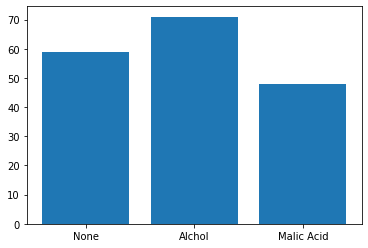

In [306]:
plt.bar(["None","Alchol","Malic Acid"],[df.loc[df["Labels"]==0].shape[0],df.loc[df["Labels"]==1].shape[0], \
                                        df.loc[df["Labels"]==2].shape[0]])
plt.show()

In [307]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,Labels
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


<h2>Perform K means Clustering</h2>

/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


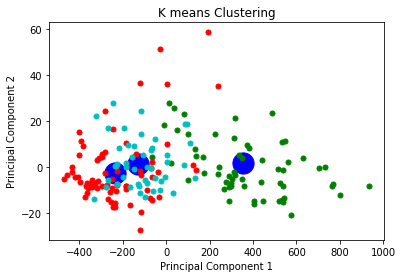

In [308]:
# Let us take the number of clusters as k
k = 3

scaled_data = (data - np.mean(data,axis=0))/np.std(data,axis=0)
kmeans = KMeans(n_clusters=k)
kmeans.fit(scaled_data)


centroids = kmeans.cluster_centers_
labels = kmeans.labels_


# did -ve of reduced  pca data because my custom pca gives -ve of eigen vectors compared to inbuilt pca

# apply pca to reduce the dimensions to two dimensions
_,_,_,reduced_dim_data_centroids = gmm_model.apply_pca(np.vstack((data,(np.std(data,axis=0)*centroids)+np.mean(data,axis=0))),2)


colors = ["g.", "r.", "c.", "b.", "k.", "o."]


for i in range(len(reduced_dim_data_centroids[:reduced_dim_data_centroids.shape[0] - centroids.shape[0]])):
    plt.plot(-reduced_dim_data_centroids[i][0], -reduced_dim_data_centroids[i][1], colors[target[i]], markersize=10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('K means Clustering')

plt.scatter(-reduced_dim_data_centroids[reduced_dim_data_centroids.shape[0] - centroids.shape[0] :, 0],-reduced_dim_data_centroids[reduced_dim_data_centroids.shape[0] - centroids.shape[0]: , 1], marker='o',color='b', s=450)
plt.show()

<h2>Tuning the hyperparameter of number of clusters using AIC and BIC scores</h2>

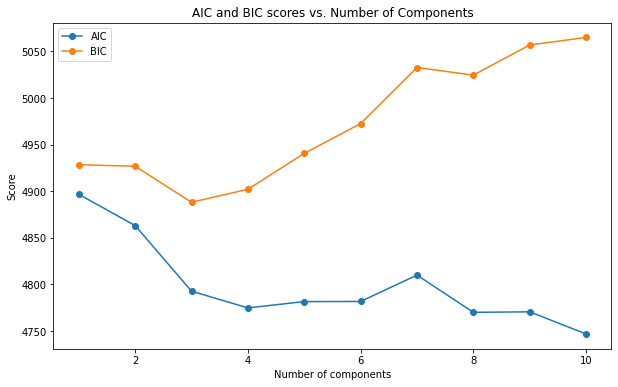

In [310]:
# apply AIC BIC scores

n_clusters = range(1, 11)  # Adjust the range if necessary
aics = []
bics = []

for n_cluster in n_clusters:
    # Initialize and fit the GMM
    gmm_model = GMM()
    gmm_model.fit(data,n_cluster)
    
    # Append AIC and BIC to lists
    aics.append(gmm_model.compute_aic())
    bics.append(gmm_model.compute_bic())

# Plot AIC and BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, aics, label='AIC', marker='o')
plt.plot(n_clusters, bics, label='BIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('AIC and BIC scores vs. Number of Components')
plt.legend()
plt.show()


In the above graph we can observe :
- Number of clusters = 3 yields the best AIC and BIC (simultaneously)


<h2>Plotting the clusters thus formed by GMM</h2>

In [311]:
gmm_model = GMM()
gmm_model.fit(data,3)

In [312]:
# store all the possible cluster id's for which the point has maximum likelihood to belong to
membership_status = gmm_model.predict_membership()
_,_,_,reduced_dimensions = gmm_model.apply_pca(data,2)

In [313]:
membership_status

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       2, 0])

In [314]:
reduced_dimensions.shape

(178, 2)

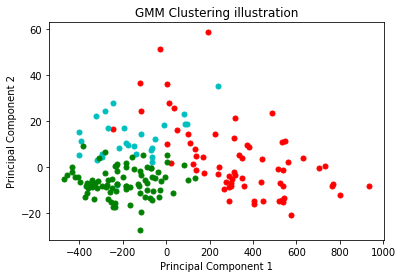

In [315]:
"""
SCATTER PLOT
"""

colors = ["g.", "r.","c."]

for i in range(reduced_dimensions.shape[0]):
    plt.plot(-reduced_dimensions[i,0],-reduced_dimensions[i,1], colors[membership_status[i]],markersize=10)

plt.title('GMM Clustering illustration')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

<h2>KNN vs GMM (Silhoutte Scores)</h2>

/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

Text(0.5, 1.0, 'Silhoutte score vs number of cluster of KMeans')

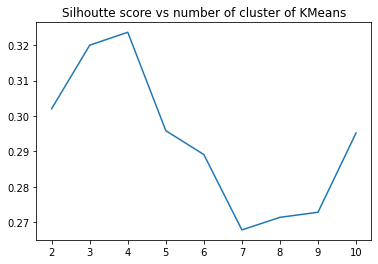

In [316]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std_pca = scaler.fit_transform(-gmm_model.reduced_pca_data)


sil_score=[]
for cluster in range(2,11):
    kmeans = KMeans(n_clusters=cluster)
    kmeans_labels = kmeans.fit_predict(std_pca)
    kmeans_silhouette = silhouette_score(std_pca, kmeans_labels)
    
    sil_score.append(kmeans_silhouette)
# #     print(f"KMeans Silhouette Score: {kmeans_silhouette}")

plt.plot(list(range(2,11)),sil_score)
plt.title('Silhoutte score vs number of cluster of KMeans')

Text(0.5, 1.0, 'Silhoutte score vs number of cluster of GMM')

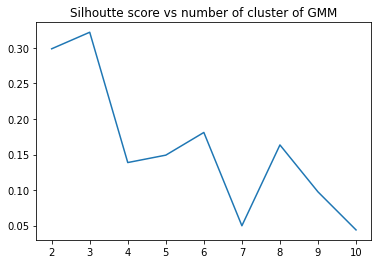

In [336]:
from sklearn.preprocessing import StandardScaler

gmm_model = GMM()
gmm_model.fit(std_pca,n_components = cluster,feature_extract=3)
    
scaler = StandardScaler()
std_pca = scaler.fit_transform(-gmm_model.reduced_pca_data)

sil_score=[]
for cluster in range(2,11):
    gmm_model = GMM()
    gmm_model.fit(std_pca,n_components = cluster,feature_extract=3,flag=1)
    gmm_labels = gmm_model.predict_membership()
    gmm_silhouette = silhouette_score(std_pca, gmm_labels)
    
    sil_score.append(gmm_silhouette)

plt.plot(list(range(2,11)),sil_score)
plt.title('Silhoutte score vs number of cluster of GMM')


## Observations

1) The silhouette score measures how close each data point in one cluster is to the data points in the neighboring clusters. A higher silhouette score indicates that the clusters are well-separated.

2) The best clustering is obtained at k=3 for both Kmeans and GMM algorithm